In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numba as nb
from tqdm import tqdm
from numba_progress import ProgressBar

# set fig size
plt.rcParams['figure.figsize'] = [16, 10]

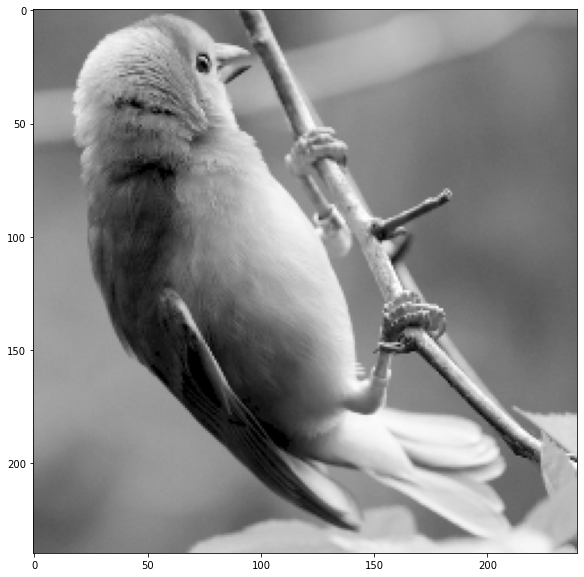

In [ ]:
# Load the input image
img = cv2.imread('input.png', cv2.IMREAD_GRAYSCALE)
# Resize the image
img = cv2.resize(img, (0,0), fx=0.5, fy=0.5) # 0.5 represents 50% scale giving image of 300 x 300
# Display the image
plt.imshow(img, cmap='gray')

In [ ]:
img.shape[0]

240

In [ ]:
# convert img to numppy array
img = np.array(img)

In [ ]:
# Compute the DFT of the image
@nb.jit(parallel=True)
def dft_numba(img, progress_proxy):
    dft = np.zeros_like(img, dtype=np.complex128)
    for y in nb.prange(img.shape[0]):
        progress_proxy.update(1)
        for x in range(img.shape[1]):
            y_range = np.arange(img.shape[0]).reshape(-1, 1)
            x_range = np.arange(img.shape[1])
            dft[y, x] = np.sum(img * np.exp(-2j * np.pi * (x*x_range / img.shape[1] + y*y_range/img.shape[0])))
    return dft


with ProgressBar(total=img.shape[0]) as progress:
    dft =  dft_numba(img, progress)

  0%|          | 0/240 [00:00<?, ?it/s]

In [ ]:
# # Compute the DFT of the image
# dft = np.zeros_like(img, dtype=np.complex128)
# for y in tqdm(range(img.shape[0])):
#     for x in range(img.shape[1]):
#         dft[y, x] = np.sum(img * np.exp(-2j * np.pi * (x*np.arange(img.shape[1]) /
#                            img.shape[1] + y*np.arange(img.shape[0])[:, np.newaxis]/img.shape[0])))

In [ ]:
dft_copy = dft.copy()

In [ ]:
dft

array([[ 7.70328900e+06     +0.j        ,
        -2.31357272e+05+512423.95870747j,
         2.33836483e+05-273345.5323201j , ...,
         7.83555788e+04 +65026.09823041j,
         2.33836483e+05+273345.5323201j ,
        -2.31357272e+05-512423.95870749j],
       [ 5.05029204e+05 -15831.12107135j,
        -1.83499512e+05+353168.27639535j,
        -1.32185701e+05-247682.71342691j, ...,
         1.69243482e+05-258464.03314898j,
        -7.53423466e+05-246118.81028391j,
         4.81650354e+05+382633.2938217j ],
       [ 1.27825576e+05+138364.12205868j,
        -2.64246217e+05-118372.69007001j,
        -1.17112893e+05 +83973.72933904j, ...,
        -6.61746306e+04+137712.62865087j,
         3.18554432e+05-193217.40514381j,
        -1.21105056e+05-116659.76860646j],
       ...,
       [-6.44138607e+04+141419.90484593j,
         6.32050409e+04 +91613.93488372j,
         1.65239024e+05  -1916.45010815j, ...,
        -3.87087813e+04 -19745.95576566j,
        -7.50209608e+04-106849.38246963j,

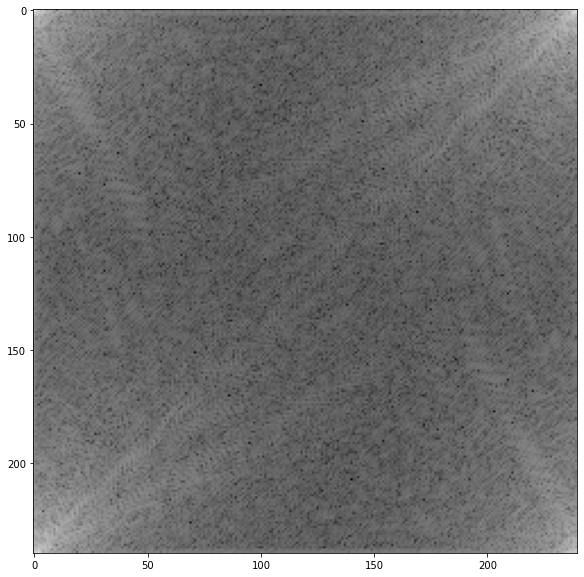

In [ ]:
# Display the magnitude of the DFT
plt.imshow(np.log(np.abs(dft_copy)), cmap='gray')

# Dark black spots shows the high frequencies in the Fourier domain

In [ ]:
np.max(np.abs(dft_copy))

7703289.0

In [ ]:
# Find mean of the DFT magnitude
mean = np.mean(np.abs(dft_copy))
mean

3318.943607292768

In [ ]:
# Identify and remove high-frequency components
dft_mag = np.abs(dft)
thresh = 0.001 * np.max(dft_mag)
dft[dft_mag < thresh] = 0

C:\Users\Sanjana MCS\AppData\Local\Temp\ipykernel_5768\3814777856.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(dft)), cmap='gray')


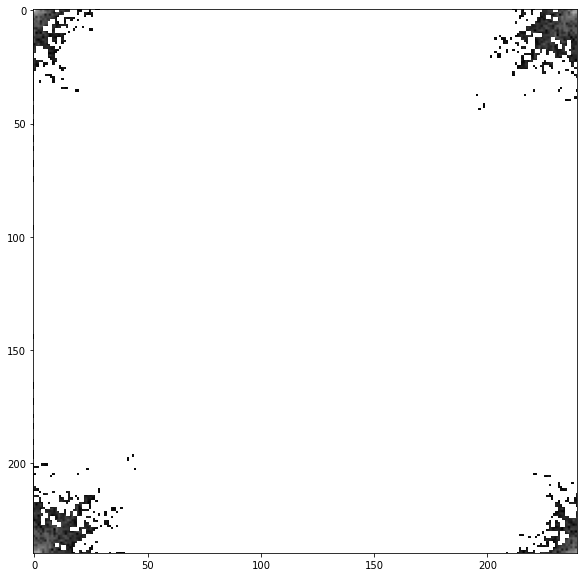

In [ ]:
```plt.imshow(np.log(np.abs(dft)), cmap='gray')```

In [ ]:
# # Compute the inverse DFT of the modified image
# img_comp = np.zeros_like(img, dtype=np.float64)
# for y in tqdm(range(img.shape[0])):
#     for x in range(img.shape[1]):
#         img_comp[y, x] = np.real(np.sum(dft * np.exp(2j * np.pi * (x*np.arange(
#             img.shape[1])/img.shape[1] + y*np.arange(img.shape[0])[:, np.newaxis]/img.shape[0]))))
# img_comp /= img.shape[0] * img.shape[1]

In [ ]:
@nb.njit(parallel=True)
def idft_numba(dft, progress_proxy):
    img_comp = np.zeros_like(dft, dtype=np.float64)
    for y in nb.prange(dft.shape[0]):
        progress_proxy.update(1)
        for x in range(dft.shape[1]):
            y_range = np.arange(dft.shape[0]).reshape(-1, 1)
            x_range = np.arange(dft.shape[1])
            img_comp[y, x] = np.real(np.sum(
                dft * np.exp(2j * np.pi * (x*x_range/dft.shape[1] + y*y_range/dft.shape[0]))))
    img_comp /= dft.shape[0] * dft.shape[1]
    return img_comp

with ProgressBar(total=img.shape[0]) as progress:
    img_comp = idft_numba(dft, progress)

  0%|          | 0/240 [00:00<?, ?it/s]

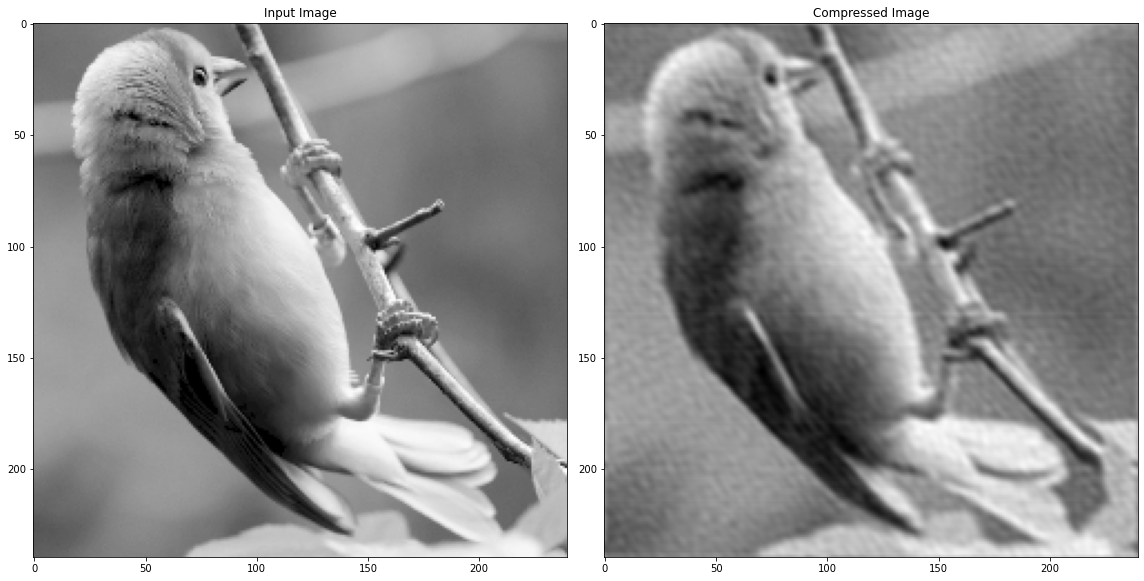

In [ ]:
# Display the input and compressed images
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Input Image')
axs[1].imshow(img_comp, cmap='gray')
axs[1].set_title('Compressed Image')
plt.tight_layout()
plt.show()

In [ ]:
# Define a plotting function, that takes in 2 images, title and a additional value to be displayed
def plot_images(img1, img2, title, val):
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    axs[0].imshow(img1, cmap='gray')
    axs[0].set_title('Input Image')
    axs[1].imshow(img2, cmap='gray')
    axs[1].set_title('Compressed Image')
    plt.suptitle(title + ' = ' + str(val))
    plt.tight_layout()
    plt.show()

In [ ]:
dft = dft_copy.copy()

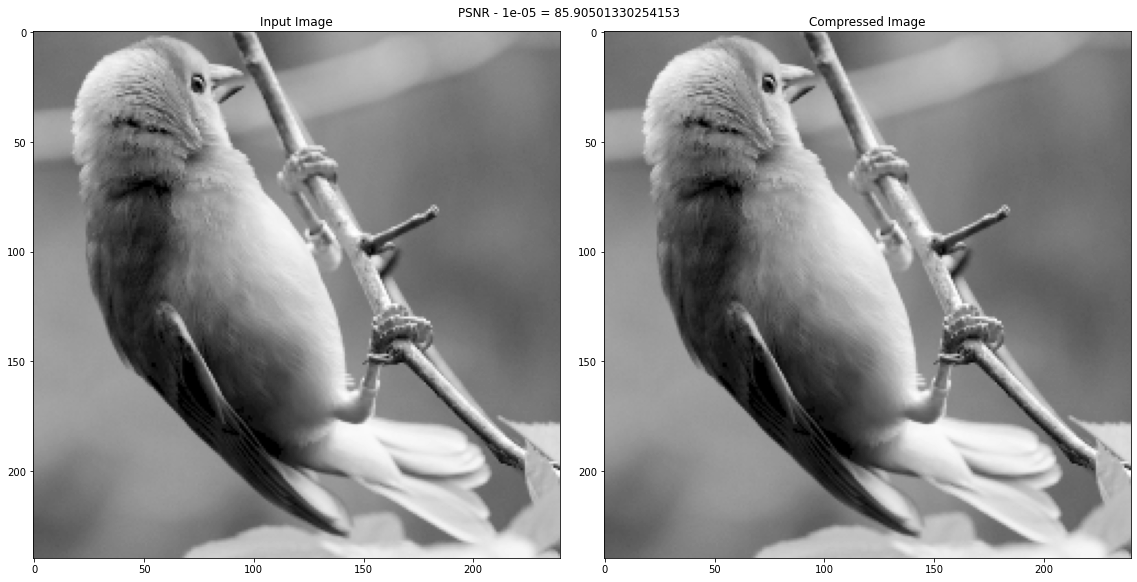

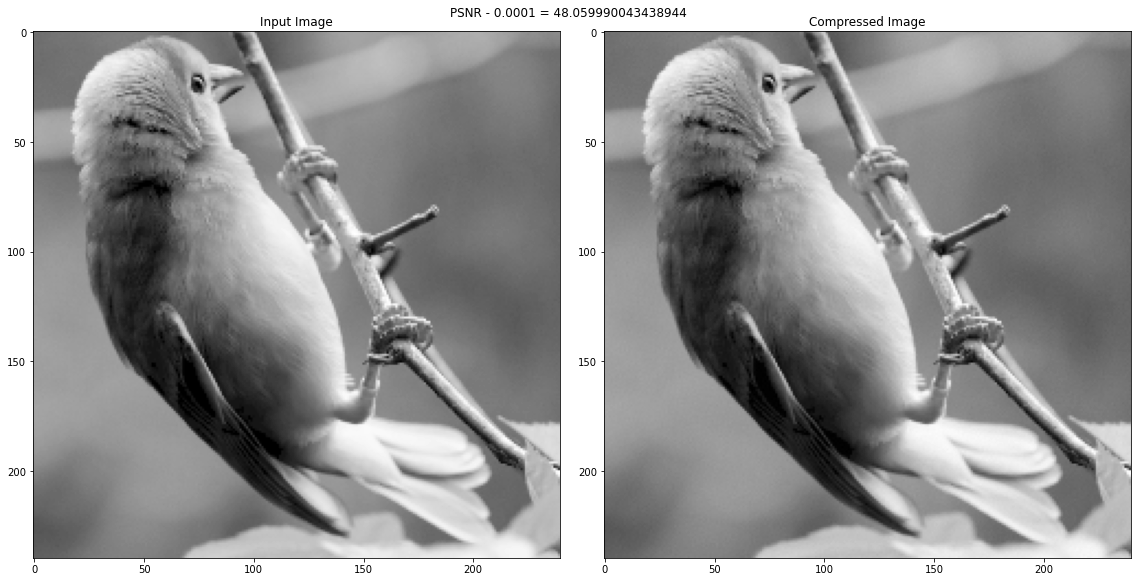

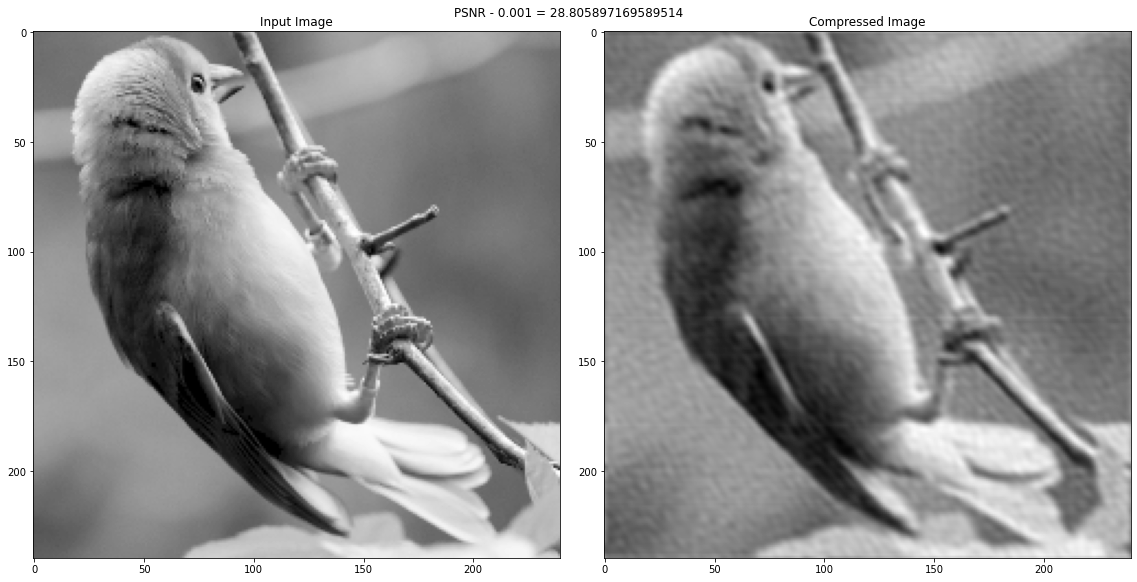

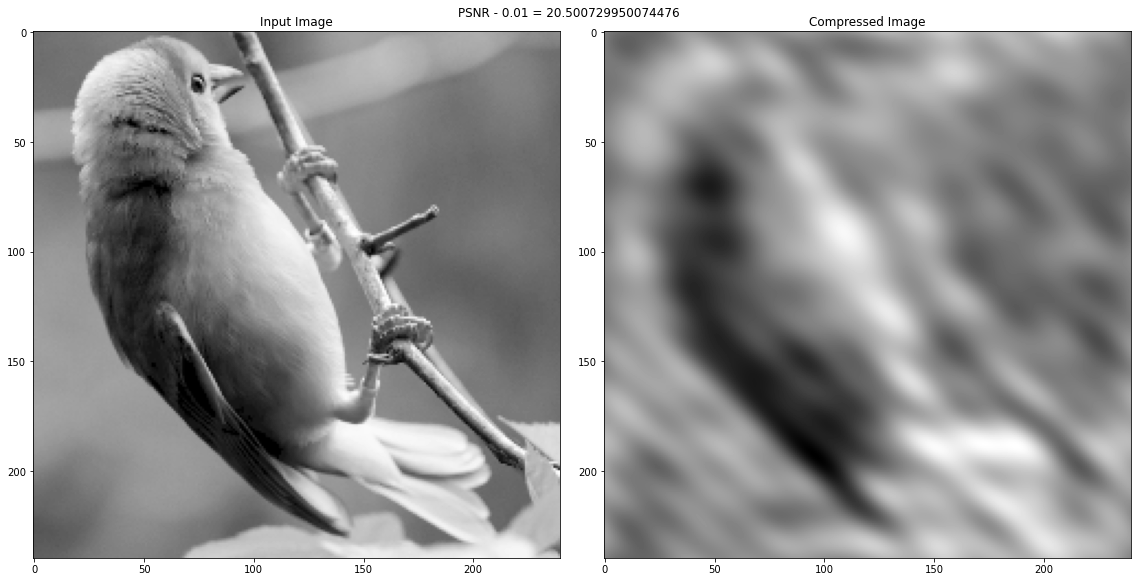

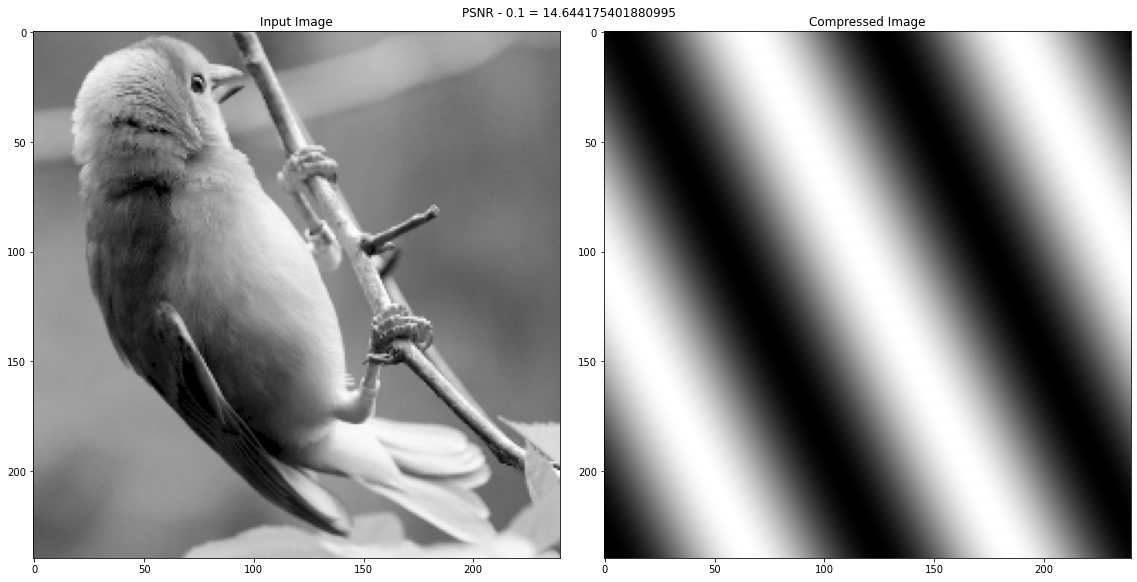

In [ ]:
for thresh in [0.00001, 0.0001, 0.001, 0.01, 0.1]:
    dft_copy = dft.copy()
    threshold = thresh * np.max(np.abs(dft_copy))
    dft_copy[np.abs(dft_copy) < threshold] = 0
    img_comp = idft_numba(dft_copy, progress)
    psnr = 10 * np.log10(255**2 / np.mean((img - img_comp)**2))
    plot_images(img, img_comp, f'PSNR - {thresh}', psnr)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2

def compress_image(img, threshold=0.1):

    # Compute 2D Fourier transform
    img_fft = fft2(img)

    # Determine threshold value
    threshold_value = np.max(np.abs(img_fft)) * threshold

    # Set high-frequency components to zero
    img_fft[np.abs(img_fft) < threshold_value] = 0

    # Compute inverse Fourier transform
    img_compressed = np.real(ifft2(img_fft))

    # Clip pixel values to [0, 255]
    img_compressed = np.clip(img_compressed, 0, 255)

    return img_compressed.astype(np.uint8)


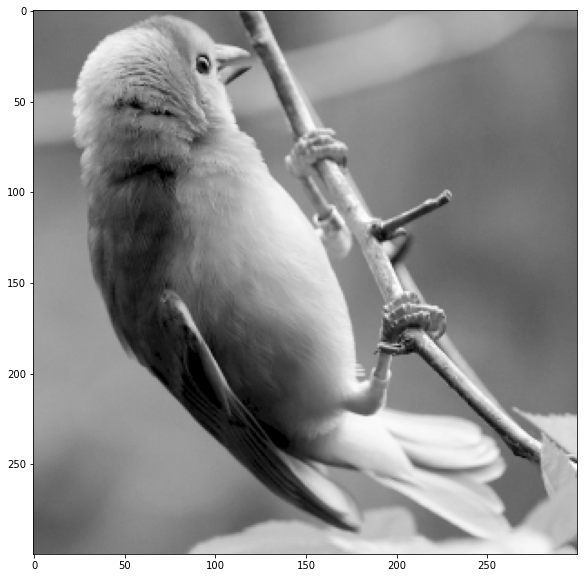

In [ ]:
# Load the input image
img = cv2.imread('input.png', cv2.IMREAD_GRAYSCALE)
# Resize the image
img = cv2.resize(img, (0,0), fx=0.5, fy=0.5)
# Display the image
plt.imshow(img, cmap='gray')

In [ ]:
img = np.array(img)

In [ ]:
img.shape

(300, 300)

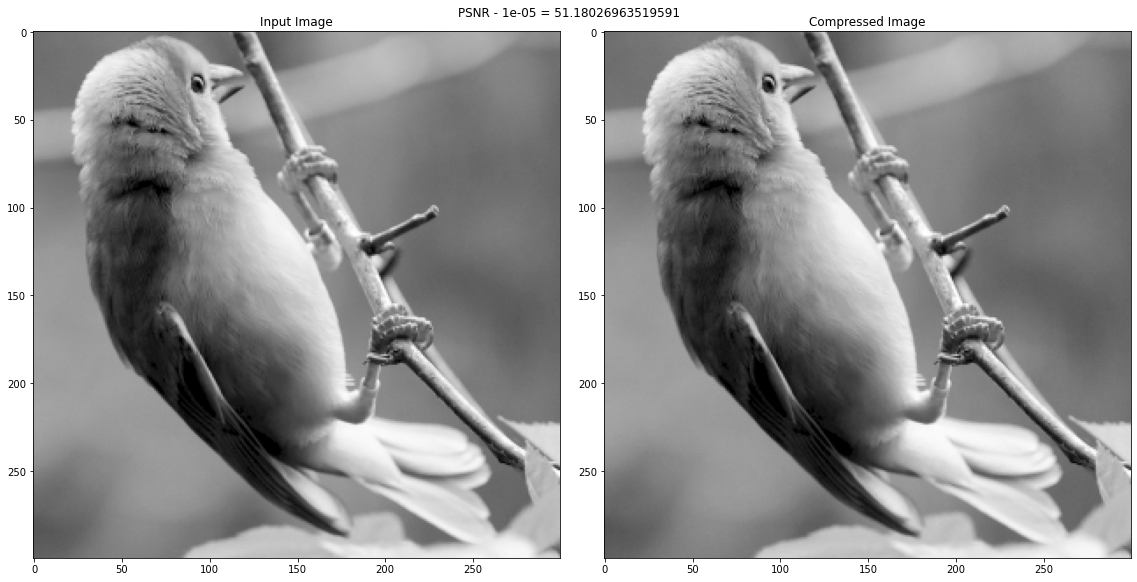

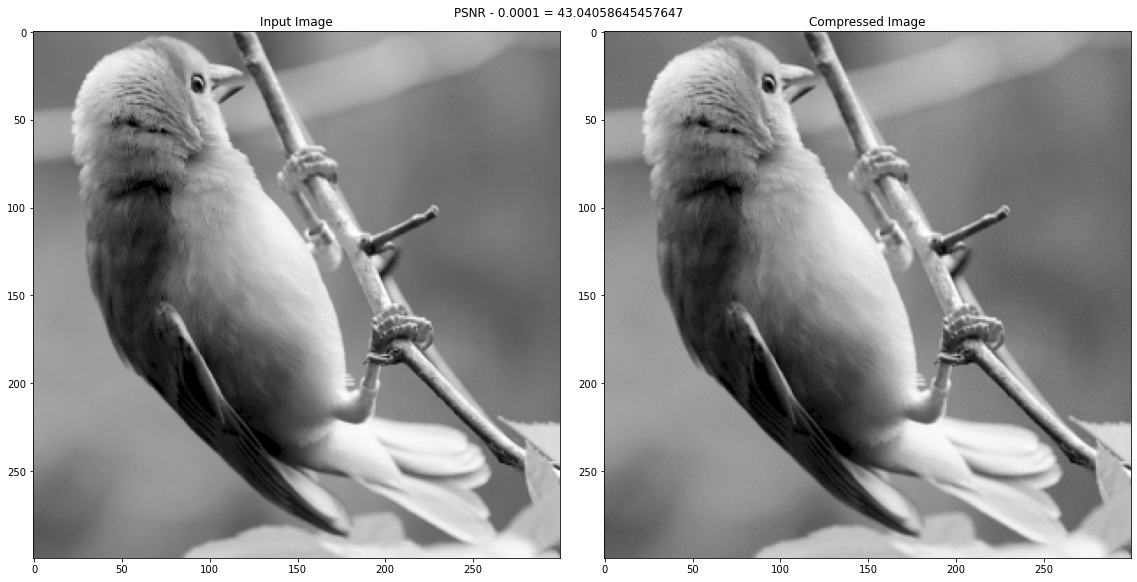

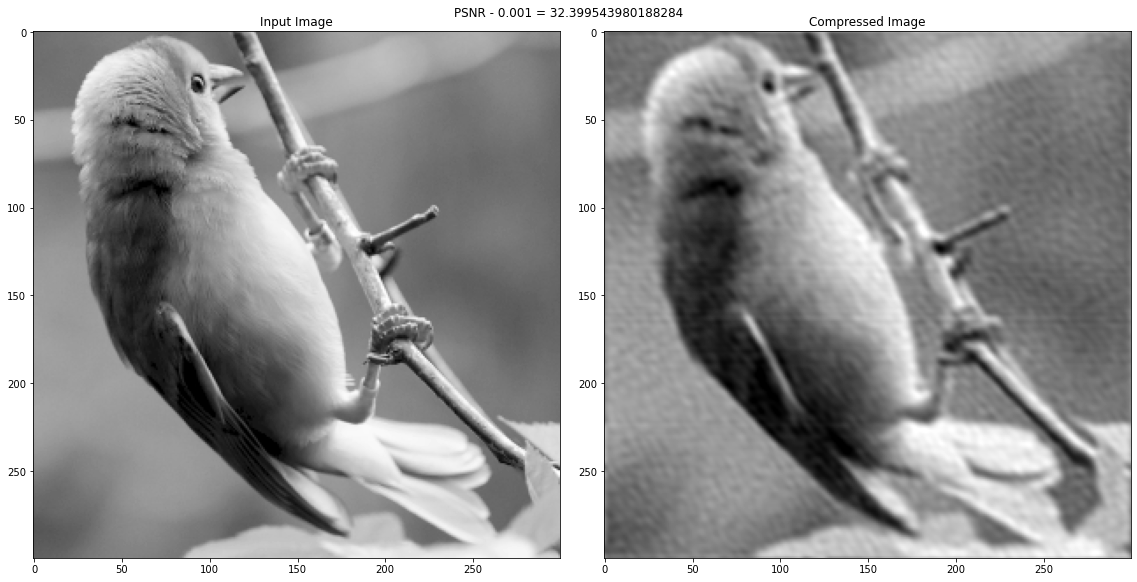

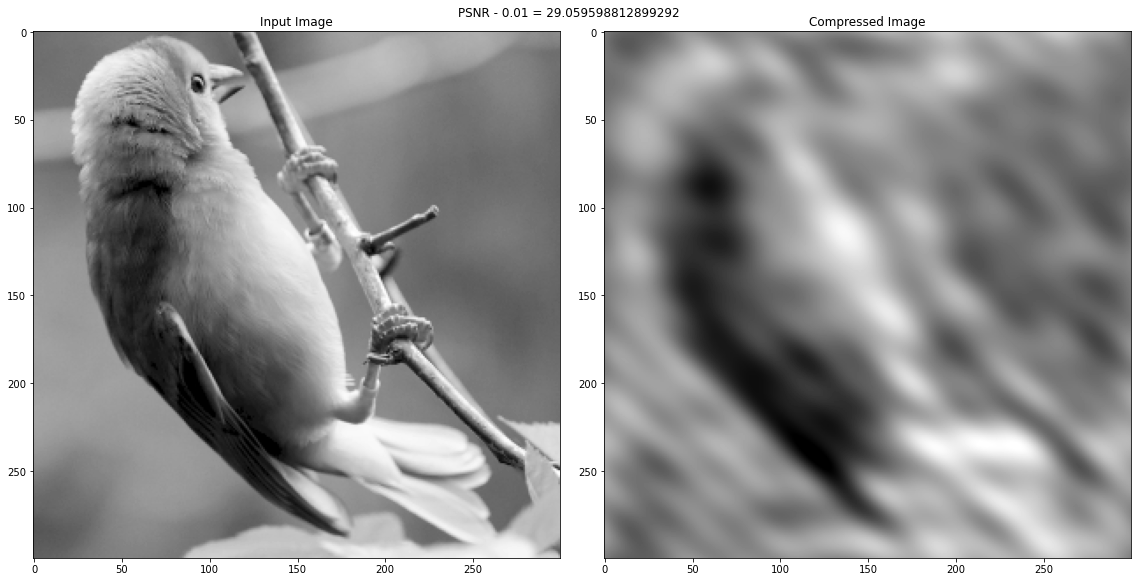

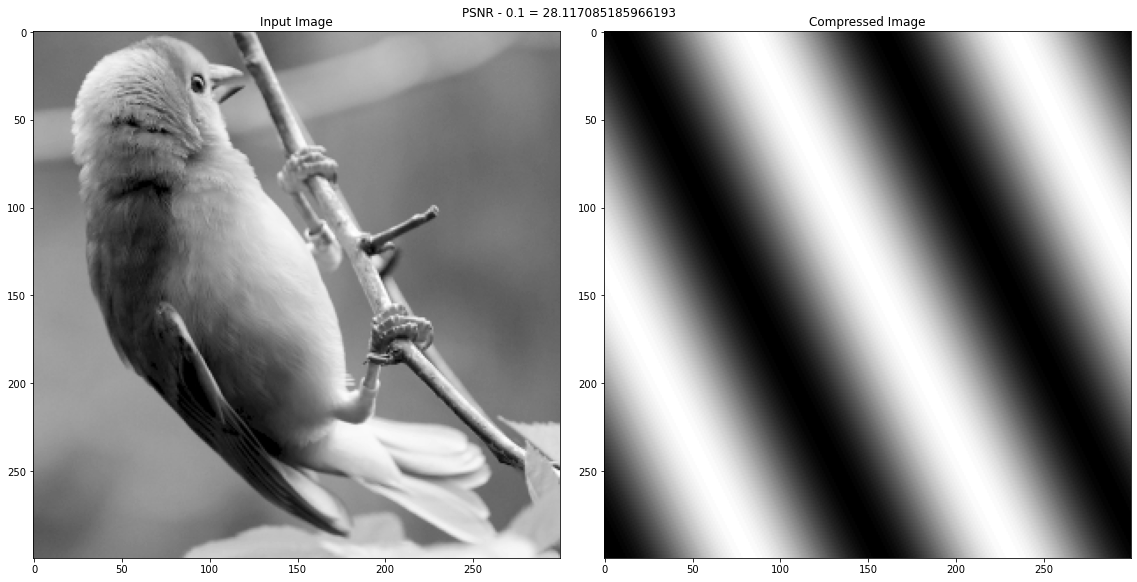

In [ ]:
for thresh in [0.00001, 0.0001, 0.001, 0.01, 0.1]:
    img_comp = compress_image(img, thresh)
    psnr = 10 * np.log10(255**2 / np.mean((img - img_comp)**2))
    plot_images(img, img_comp, f'PSNR - {thresh}', psnr)